# Training a CIFAR10 classifier

## Q1 定義神經網路模型(30/100)

- 請建構一個用於分類cifar10資料的神經網路模型
- 於1個batch data測試正常後，得30分

## Q2 訓練模型並畫出 learning curve(50/100)

- 請訓練上題所定義的神經網路
- 畫出訓練誤差的學習曲線，得50分

## Q3 於測試資料上的正確率(20/100)

- 請於測試資料上評估模型的好壞
- 給出模型於測試資料上的正確率，得20分

## 作業繳交規則

- 請將.ipynb檔名"HW-cifar10-calssification"加上"-學號"並匯出成html格式
- 將.ipynb與html上傳至e3以利批改

## 參考資料

- [Pytorch-cifar10-tutorial](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py)
- [PyTorch documentation](http://pytorch.org/docs/index.html)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import torchvision
from torchvision import datasets, transforms

# 載入CIFAR10資料

- 原始資料會下載在"./data"上一層的目錄底下

In [2]:
transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(), 
                                transforms.RandomCrop(32, padding=4),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2))
])
batch_size = 32

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transform),
    batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transform),
    batch_size=batch_size)

Files already downloaded and verified


## 取出一部分資料來視覺化

In [3]:
def show_grid_img(img_tensor):
    img_tensor = img_tensor/2 +0.5
    i = torchvision.utils.make_grid(img_tensor).numpy()
    i = np.transpose(i,(1,2,0))
    plt.imshow(i)

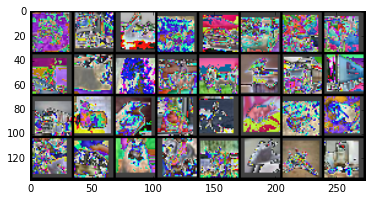

In [4]:
data,target = next(iter(train_loader))
show_grid_img(data)

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2))
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## 每一個batch的資料維度

In [6]:
data.size()

torch.Size([32, 3, 32, 32])

In [7]:
target


 6
 9
 9
 4
 1
 1
 2
 7
 8
 3
 4
 7
 7
 2
 9
 9
 9
 3
 2
 6
 4
 3
 6
 6
 2
 6
 3
 5
 4
 0
 0
 9
[torch.LongTensor of size 32]

# Q1 定義神經網路模型(30/100)

## 請根據cifar10資料特性設計神經網路架構

- 可以優先考慮使用CNN
- 對於沒有GPU環境，請先嘗試較為簡單的模型，不然計算時間會太久

In [8]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 128, 6)
        self.fc1   = nn.Linear(128*5*5, 800)
        self.fc2   = nn.Linear(800, 120)
        self.fc3   = nn.Linear(120, 10)
        
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
#     def __init__(self):
#         super(LeNet, self).__init__()
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv1 = nn.Conv2d(3, 16, 5)
#         self.conv2 = nn.Conv2d(16, 32, 5)
#         self.conv3 = nn.Conv2d(32, 64, 3)
#         self.fc1 = nn.Linear(64*5*5, 800)
#         self.fc2 = nn.Linear(800, 200)
#         self.fcf = nn.Linear(200, 10)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = self.pool(x)
#         x = F.relu(self.conv3(x))
#         x = self.pool(x)
#         x = x.view(-1, 64*5*5)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fcf(x)
#         return x

## 測試模型能否正常運作

- 輸入 [batch_size , 3 , 32 , 32 ]
- 輸出 [batch_size , 10 ]

In [9]:
net = LeNet()

In [10]:
predict = net(Variable(data))

In [11]:
predict.size()

torch.Size([32, 10])

## 測試能否計算loss

In [12]:
F.cross_entropy(predict,Variable(target))

Variable containing:
 2.3226
[torch.FloatTensor of size 1]

# Q2 訓練模型並畫出 learning curve

## 調整 batch_size

預設的 batch_size為32，可以嘗試64,128

In [13]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2))])

batch_size = 32 # you can change batch size

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=False,
                   transform=transform),
    batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transform),
    batch_size=batch_size)

## 選擇優化演算法

- 建議使用Adam
- 如想使用SGD需要仔細調整 learning_rate，或加入momentum

In [14]:
criterion = nn.CrossEntropyLoss()
# train_op = optim.SGD(net.parameters(),lr=0.0115, momentum=0.827) -> 63%
train_op = optim.Adam(net.parameters(), lr=0.0011, weight_decay=0.00115)
# lr=0.0011, weight_decay=0.001 -> 63.69%
# train_op = optim.Adam(net.parameters(), lr=0.0011, weight_decay=0.00115) -> 65%

## 訓練神經網路

- n_epochs 代表要把整個訓練資料循環過幾次
- train_loss_history 用來保存每個epoch的平均 batch_train_loss

In [15]:
%%time
n_epochs = 9 #you can change here
train_loss_history = []

for epoch in range(n_epochs):
    batch_train_loss_ = []
    
    if epoch < 3:
        train_op = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    elif epoch < 6:
        train_op = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    else:
        train_op = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
        
    for _, (data, target) in enumerate(train_loader):

        # get the inputs
        inputs, labels = data, target
        
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)
        
        # zero the parameter gradients
        train_op.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        batch_train_loss = criterion(outputs, labels)
        batch_train_loss.backward()
        train_op.step()
        
        batch_train_loss_.append(batch_train_loss.data[0])
    
    batch_train_loss = np.mean(batch_train_loss_)
    train_loss_history.append(batch_train_loss)
    print "epoch:%s , train_loss:%s" % (epoch , batch_train_loss)

epoch:0 , train_loss:1.45253834264
epoch:1 , train_loss:0.995176814454
epoch:2 , train_loss:0.767542924339
epoch:3 , train_loss:0.428750594782
epoch:4 , train_loss:0.310548560991
epoch:5 , train_loss:0.224580874043
epoch:6 , train_loss:0.15730594229
epoch:7 , train_loss:0.143809305899
epoch:8 , train_loss:0.135055141621
CPU times: user 54min 49s, sys: 36min 52s, total: 1h 31min 42s
Wall time: 45min 58s


## 畫出每個 epoch對 train_loss learning curve

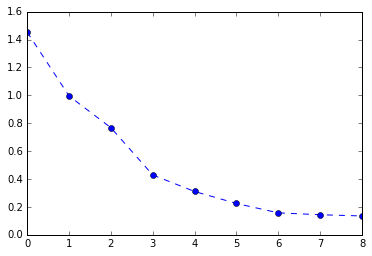

In [16]:
plt.plot(range(0,epoch+1) , train_loss_history,'o--')

# Q3 於測試資料上的正確率

In [17]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 80 %
Accuracy of   car : 85 %
Accuracy of  bird : 64 %
Accuracy of   cat : 58 %
Accuracy of  deer : 71 %
Accuracy of   dog : 66 %
Accuracy of  frog : 79 %
Accuracy of horse : 79 %
Accuracy of  ship : 84 %
Accuracy of truck : 81 %


In [18]:
correct = 0
n_testsets = 10000.0

for _, (data, target) in enumerate(test_loader):
    images, labels = data, target
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == labels).sum()

In [19]:
correct / n_testsets

0.7506